In [73]:
from bs4 import BeautifulSoup
import requests
import requests_cache
from PandasBasketball import pandasbasketball as pb
from PandasBasketball.stats import player_stats, team_stats, player_gamelog, n_days
# from PandasBasketball.errors import StatusCode404, TableNonExistent 

In [2]:
requests_cache.install_cache('request_cache')

In [3]:
# Generate list of letter directories for player names (by their last names)
import string

letters = string.ascii_lowercase
players_letter_dirs = [f"http://www.basketball-reference.com/players/{letter}/" for letter in letters]
players_letter_dirs[:2]

['http://www.basketball-reference.com/players/a/',
 'http://www.basketball-reference.com/players/b/']

In [6]:
reqs = [requests.get(url) for url in players_letter_dirs]
reqs[:4]

[<Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>]

In [7]:
requests.get('http://www.basketball-reference.com/players/f').from_cache

True

## Scrape player list pages for all names and the file name conventions for each

In [8]:
'''
The player name to file naming convention should be a dictionary with player name being key.
This will give a user the ability to lookup naming convention by name
'''
from bs4 import BeautifulSoup
from PandasBasketball.stats import get_data_master

f_request = requests.get("http://www.basketball-reference.com/players/f")
soup = BeautifulSoup(f_request.text, "html.parser")
player_table = soup.find("table", id="players")
df = get_data_master(player_table, "player")
df.head(1)

,Player,From,To,Pos,Ht,Wt,Birth Date,Colleges
0,Joe Fabel,1947,1947,F-G,6-1,190,"May 15, 1917",Pitt


## Retrieve full list of players all time and their filename encodings

In [9]:
# Generate list of player tables, one from each letter directory
players_tables = []
for letter_dir in players_letter_dirs:
    r = requests.get(letter_dir)
    soup = BeautifulSoup(r.text, "html.parser")
    players_table = soup.find("table", id="players")
    players_tables.append(players_table)

In [10]:
# Generate dictionary mapping every player name to their respective name encoding

player_dict = {}

for players_table in players_tables:
    players_name_rows = players_table.find("tbody").find_all("th")
    filenames = [row["data-append-csv"] for row in players_name_rows]

    for row in players_name_rows:
        split_name = row.a.text.split()
        first = split_name[0]
        last = split_name[-1]
        encoding = row["data-append-csv"]
        player_dict[f"{first} {last}"] = encoding

player_dict    



{'Alaa Abdelnaby': 'abdelal01',
 'Zaid Abdul-Aziz': 'abdulza01',
 'Kareem Abdul-Jabbar': 'abdulka01',
 'Mahmoud Abdul-Rauf': 'abdulma02',
 'Tariq Abdul-Wahad': 'abdulta01',
 'Shareef Abdur-Rahim': 'abdursh01',
 'Tom Abernethy': 'abernto01',
 'Forest Able': 'ablefo01',
 'John Abramovic': 'abramjo01',
 'Álex Abrines': 'abrinal01',
 'Alex Acker': 'ackeral01',
 'Don Ackerman': 'ackerdo01',
 'Mark Acres': 'acresma01',
 'Bud Acton': 'actonbu01',
 'Quincy Acy': 'acyqu01',
 'Alvan Adams': 'adamsal01',
 'Don Adams': 'adamsdo01',
 'George Adams': 'adamsge01',
 'Hassan Adams': 'adamsha01',
 'Jaylen Adams': 'adamsja01',
 'Jordan Adams': 'adamsjo01',
 'Michael Adams': 'adamsmi01',
 'Steven Adams': 'adamsst01',
 'Rafael Addison': 'addisra01',
 'Bam Adebayo': 'adebaba01',
 'Deng Adel': 'adelde01',
 'Rick Adelman': 'adelmri01',
 'Jeff Adrien': 'adrieje01',
 'Arron Afflalo': 'afflaar01',
 'Maurice Ager': 'agerma01',
 'Mark Aguirre': 'aguirma01',
 'Blake Ahearn': 'ahearbl01',
 'Danny Ainge': 'aingeda01'

In [19]:
# Get list of every player page to be scraped
full_player_urls = []
for letter_dir in players_letter_dirs:
    for encoding in player_dict.values():
        if encoding.startswith(letter_dir[-2]):
            full_player_urls.append(letter_dir+encoding+".html")
full_player_urls[50:6000:200]

['http://www.basketball-reference.com/players/a/alexaky01.html',
 'http://www.basketball-reference.com/players/b/battljo01.html',
 'http://www.basketball-reference.com/players/b/bradldu01.html',
 'http://www.basketball-reference.com/players/c/cannola01.html',
 'http://www.basketball-reference.com/players/c/corleke01.html',
 'http://www.basketball-reference.com/players/d/dickehe01.html',
 'http://www.basketball-reference.com/players/e/evansre01.html',
 'http://www.basketball-reference.com/players/g/garriki01.html',
 'http://www.basketball-reference.com/players/h/hagangl01.html',
 'http://www.basketball-reference.com/players/h/higgske01.html',
 'http://www.basketball-reference.com/players/j/jamesju01.html',
 'http://www.basketball-reference.com/players/k/keefead01.html',
 'http://www.basketball-reference.com/players/l/lawsoja01.html',
 'http://www.basketball-reference.com/players/m/markkla01.html',
 'http://www.basketball-reference.com/players/m/mercero01.html',
 'http://www.basketball-r

In [32]:
# Generate full player dataframe concatenated
import random
import pandas as pd

dfs = [player_stats(requests.get(url), "per_minute") for url in random.sample(full_player_urls, 5)]
all_stats = pd.concat(dfs)
all_stats[::5]
#     print(url)

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019-20,23,CLE,NBA,PF,12,0,71,4.6,6.6,...,.000,1.5,8.1,9.6,1.0,1.0,2.0,1.5,4.1,10.1
4,1953-54,28,NYK,NBA,PG,68,,2343,3.1,7.6,...,.638,NaN,NaN,4.8,5.4,NaN,NaN,NaN,3.1,9.6
9,1958-59,33,DET,NBA,PG,71,,2063,4.0,9.5,...,.740,NaN,NaN,5.0,7.7,NaN,NaN,NaN,2.6,11.4
2,2002-03,26,TOT,NBA,SG,53,1,559,2.6,7.1,...,.727,1.2,2.4,3.7,4.8,1.2,0.4,2.2,3.3,7.8
0,1995-96,24,WSB,NBA,SF,11,0,58,5.0,14.3,...,,1.2,3.1,4.3,1.9,2.5,0.0,1.9,4.3,11.2


In [37]:
import matplotlib.pyplot as plt
import sqlite3

In [41]:
conn = sqlite3.connect('all_player_stats.db')
c = conn.cursor()

In [44]:
all_stats.to_sql("all_players", conn)

In [48]:
sql = "show tables"
# pd.read_sql(sql, conn)

In [69]:
sql = "select * from all_players"
c.execute(sql).fetchall()[0][:5]

(0, '2019-20', '23', 'CLE', 'NBA')

In [83]:
harden = pd.concat([pb.get_player_gamelog("hardeja01","2010"),pb.get_player_gamelog("hardeja01","2011"),pb.get_player_gamelog("hardeja01","2012"),
                   pb.get_player_gamelog("hardeja01","2013"),pb.get_player_gamelog("hardeja01","2014"),pb.get_player_gamelog("hardeja01","2015"),
                   pb.get_player_gamelog("hardeja01","2016"),pb.get_player_gamelog("hardeja01","2017"),pb.get_player_gamelog("hardeja01","2018"),
                   pb.get_player_gamelog("hardeja01","2019")])
harden.tail()

,G,Date,Age,Tm,,Opp,,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
Rk,,,,,,,,,,,,,,,,,,,,,
78,74,2019-04-02,29-219,HOU,@,SAC,W (+25),1,29:28,12,...,3,3,10,1,0,2,2,36,33.2,+29
79,75,2019-04-03,29-220,HOU,@,LAC,W (+32),1,30:21,9,...,6,7,7,0,0,6,3,31,23.5,+16
80,76,2019-04-05,29-222,HOU,,NYK,W (+24),1,29:12,8,...,8,9,8,1,1,3,2,26,21.1,+29
81,77,2019-04-07,29-224,HOU,,PHO,W (+36),1,29:00,10,...,13,13,9,2,0,6,3,30,28.4,+39
82,78,2019-04-09,29-226,HOU,@,OKC,L (-1),1,36:58,11,...,9,10,3,1,1,4,4,39,25.0,+1


In [94]:
harden

,G,Date,Age,Tm,,Opp,,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
Rk,,,,,,,,,,,,,,,,,,,,,
1,1,2009-10-28,20-063,OKC,,SAC,W (+13),0,12:59,2,...,2,2,0,0,0,0,3,5,3.8,-5
2,2,2009-10-30,20-065,OKC,@,DET,W (+8),0,16:38,1,...,1,2,8,0,0,0,3,2,3.6,+17
3,3,2009-11-01,20-067,OKC,,POR,L (-9),0,17:52,2,...,2,3,2,1,1,1,2,6,3.1,+4
4,4,2009-11-03,20-069,OKC,,LAL,L (-3),0,17:04,3,...,1,1,3,1,0,0,2,9,6.5,+16
5,5,2009-11-06,20-072,OKC,@,HOU,L (-11),0,10:02,2,...,1,1,1,0,0,1,1,4,2.3,-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,74,2019-04-02,29-219,HOU,@,SAC,W (+25),1,29:28,12,...,3,3,10,1,0,2,2,36,33.2,+29
79,75,2019-04-03,29-220,HOU,@,LAC,W (+32),1,30:21,9,...,6,7,7,0,0,6,3,31,23.5,+16
80,76,2019-04-05,29-222,HOU,,NYK,W (+24),1,29:12,8,...,8,9,8,1,1,3,2,26,21.1,+29


In [97]:
type(harden.PTS)

pandas.core.series.Series

In [98]:
from pandas_profiling import ProfileReport

In [129]:
harden.reset_index(inplace=True)

In [141]:
harden.corr

<bound method DataFrame.corr of      Rk   G        Date     Age   Tm     Opp          GS     MP  ... DRB TRB  \
0     1   1  2009-10-28  20-063  OKC     SAC  W (+13)  0  12:59  ...   2   2   
1     2   2  2009-10-30  20-065  OKC  @  DET   W (+8)  0  16:38  ...   1   2   
2     3   3  2009-11-01  20-067  OKC     POR   L (-9)  0  17:52  ...   2   3   
3     4   4  2009-11-03  20-069  OKC     LAL   L (-3)  0  17:04  ...   1   1   
4     5   5  2009-11-06  20-072  OKC  @  HOU  L (-11)  0  10:02  ...   1   1   
..   ..  ..         ...     ...  ... ..  ...      ... ..    ...  ...  ..  ..   
799  78  74  2019-04-02  29-219  HOU  @  SAC  W (+25)  1  29:28  ...   3   3   
800  79  75  2019-04-03  29-220  HOU  @  LAC  W (+32)  1  30:21  ...   6   7   
801  80  76  2019-04-05  29-222  HOU     NYK  W (+24)  1  29:12  ...   8   9   
802  81  77  2019-04-07  29-224  HOU     PHO  W (+36)  1  29:00  ...  13  13   
803  82  78  2019-04-09  29-226  HOU  @  OKC   L (-1)  1  36:58  ...   9  10   

    AST

In [186]:
mj = pd.concat([pb.get_player_gamelog("jordami01","1985", playoffs=True),pb.get_player_gamelog("jordami01","1986", playoffs=True),pb.get_player_gamelog("jordami01","1987", playoffs=True),
                   pb.get_player_gamelog("jordami01","1988", playoffs=True),pb.get_player_gamelog("jordami01","1989", playoffs=True),pb.get_player_gamelog("jordami01","1990", playoffs=True),
                   pb.get_player_gamelog("jordami01","1991", playoffs=True),pb.get_player_gamelog("jordami01","1992", playoffs=True),pb.get_player_gamelog("jordami01","1993", playoffs=True)])
mj.reset_index(inplace=True)
mj.head()

,Rk,G,Date,Age,Tm,,Opp,,GS,MP,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc
0,1,1,1985-04-19,22-061,CHI,@,MIL,L (-9),1,44:00,...,1,3,4,10,3,0,1,3,23,21.5
1,2,2,1985-04-21,22-063,CHI,@,MIL,L (-7),1,43:00,...,1,3,4,12,2,0,7,5,30,24.3
2,3,3,1985-04-24,22-066,CHI,,MIL,W (+2),1,42:00,...,3,5,8,7,4,1,3,4,35,28.2
3,4,4,1985-04-26,22-068,CHI,,MIL,L (-8),1,42:00,...,2,5,7,5,2,3,4,3,29,24.3
4,1,1,1986-04-17,23-059,CHI,@,BOS,L (-19),1,43:00,...,0,4,4,2,2,1,5,3,49,29.3


In [189]:
cols = mj.columns
cols

Index(['Rk', 'G', 'Date', 'Age', 'Tm', ' ', 'Opp', ' ', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc'],
      dtype='object')

In [215]:
mj.PTS = mj.PTS.apply(pd.to_numeric)

In [260]:
mj.Date = mj.Date.apply(pd.to_datetime)
mj[cols[10:]] = mj[cols[10:]].apply(pd.to_numeric)



,Rk,G,Date,Age,Tm,,Opp,,GS,MP,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc
0,1,1,1985-04-19,22-061,CHI,@,MIL,L (-9),1,44:00,...,1,3,4,10,3,0,1,3,23,21.5
1,2,2,1985-04-21,22-063,CHI,@,MIL,L (-7),1,43:00,...,1,3,4,12,2,0,7,5,30,24.3
2,3,3,1985-04-24,22-066,CHI,,MIL,W (+2),1,42:00,...,3,5,8,7,4,1,3,4,35,28.2
3,4,4,1985-04-26,22-068,CHI,,MIL,L (-8),1,42:00,...,2,5,7,5,2,3,4,3,29,24.3
4,1,1,1986-04-17,23-059,CHI,@,BOS,L (-19),1,43:00,...,0,4,4,2,2,1,5,3,49,29.3
5,2,2,1986-04-20,23-062,CHI,@,BOS,L (-4),1,53:00,...,1,4,5,6,3,2,4,4,63,47.2
6,3,3,1986-04-22,23-064,CHI,,BOS,L (-18),1,39:00,...,4,6,10,9,2,1,5,6,19,15.4
7,1,1,1987-04-23,24-065,CHI,@,BOS,L (-4),1,44:00,...,0,6,6,7,4,2,2,4,35,30.8
8,2,2,1987-04-26,24-068,CHI,@,BOS,L (-9),1,45:00,...,1,3,4,4,0,4,4,3,42,28.5
9,3,3,1987-04-28,24-070,CHI,,BOS,L (-11),1,39:00,...,6,5,11,7,2,1,2,4,30,21.5


In [295]:
# fig, ax = plt.subplots()
mj.PTS.dt.day.plot.line()


0      19
1      21
2      24
3      26
4      17
5      20
6      22
7      23
8      26
9      28
10     28
11      1
12      3
13      5
14      8
15     10
16     12
17     14
18     15
19     18
20     28
21     30
22      3
23      5
24      7
25      9
26     11
27     13
28     14
29     16
30     19
31     21
32     23
33     27
34     29
35     31
36      2
37     27
38     29
39      1
40      3
41      7
42      9
43     11
44     13
45     16
46     20
47     22
48     26
49     28
50     30
51      1
52      3
53     25
54     28
55     30
56      4
57      6
58     10
59     12
60     14
61     19
62     21
63     25
64     27
65      2
66      5
67      7
68      9
69     12
70     24
71     26
72     29
73      5
74      7
75      9
76     10
77     12
78     14
79     17
80     19
81     21
82     23
83     25
84     27
85     29
86      3
87      5
88      7
89     10
90     12
91     14
92     30
93      2
94      4
95     11
96     13
97     15
98     17
99     23


In [291]:
pd.options.plotting.backend

['AST',
 'Age',
 'BLK',
 'DRB',
 'Date',
 'FG',
 'FGA',
 'FT',
 'FTA',
 'G',
 'GS',
 'GmSc',
 'MP',
 'ORB',
 'Opp',
 'PF',
 'PTS',
 'Rk',
 'STL',
 'T',
 'TOV',
 'TRB',
 'Tm',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul

In [278]:
mj['PTS'].var()

87.30876330876332

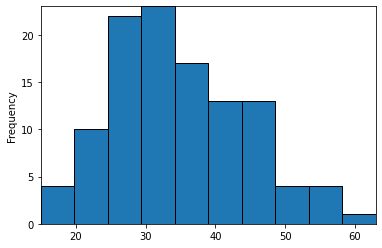

In [281]:
mj.PTS.plot.hist(edgecolor='k').autoscale(enable=True, axis='both',tight=True)

In [302]:
type(mj.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [323]:
# def sampling(df, sample_rule):
#     df.resample(rule=f"{sample_rule}")
# sampling(mj, 'A')
mj = mj.set_index(mj.Date).drop('Rk', axis=1)
mj.head()

,G,Date,Age,Tm,,Opp,,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc
Date,,,,,,,,,,,,,,,,,,,,,
1985-04-19,1,1985-04-19,22-061,CHI,@,MIL,L (-9),1,44:00,7,...,1,3,4,10,3,0,1,3,23,21.5
1985-04-21,2,1985-04-21,22-063,CHI,@,MIL,L (-7),1,43:00,9,...,1,3,4,12,2,0,7,5,30,24.3
1985-04-24,3,1985-04-24,22-066,CHI,,MIL,W (+2),1,42:00,12,...,3,5,8,7,4,1,3,4,35,28.2
1985-04-26,4,1985-04-26,22-068,CHI,,MIL,L (-8),1,42:00,6,...,2,5,7,5,2,3,4,3,29,24.3
1986-04-17,1,1986-04-17,23-059,CHI,@,BOS,L (-19),1,43:00,18,...,0,4,4,2,2,1,5,3,49,29.3


In [325]:
mj.resample(rule='A').mean()

,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc
Date,,,,,,,,,,,,,,,,,,,
1985-12-31,8.500000,19.500000,0.433500,0.250000,2.000000,0.062500,12.000000,14.500000,0.838750,1.750000,4.000000,5.750000,8.500000,2.750000,1.000000,3.750000,3.750000,29.250000,24.575000
1986-12-31,16.000000,31.666667,0.493667,0.333333,0.333333,1.000000,11.333333,13.000000,0.813000,1.666667,4.666667,6.333333,5.666667,2.333333,1.333333,4.666667,4.333333,43.666667,30.633333
1987-12-31,11.666667,28.000000,0.421000,0.666667,1.666667,0.222333,11.666667,13.000000,0.904667,2.333333,4.666667,7.000000,6.000000,2.000000,2.333333,2.666667,3.666667,35.666667,26.933333
1988-12-31,13.800000,26.000000,0.526700,0.100000,0.300000,0.250000,8.600000,9.900000,0.831500,2.300000,4.800000,7.100000,4.700000,2.400000,1.100000,3.900000,3.800000,36.300000,27.190000
1989-12-31,11.705882,22.941176,0.510824,0.588235,2.058824,0.284235,10.764706,13.470588,0.781118,1.529412,5.470588,7.000000,7.647059,2.470588,0.764706,4.000000,3.823529,34.764706,27.847059
1990-12-31,13.687500,26.625000,0.504250,1.000000,3.125000,0.290214,8.312500,9.937500,0.836688,1.500000,5.687500,7.187500,6.812500,2.812500,0.875000,3.500000,3.375000,36.687500,28.975000
1991-12-31,11.588235,22.117647,0.532059,0.588235,1.529412,0.378231,7.352941,8.705882,0.829765,1.058824,5.294118,6.352941,8.352941,2.352941,1.352941,2.529412,3.117647,31.117647,27.429412
1992-12-31,13.181818,26.409091,0.496273,0.772727,2.000000,0.372167,7.363636,8.590909,0.862318,1.681818,4.545455,6.227273,5.772727,2.000000,0.727273,3.681818,2.818182,34.500000,25.077273
1993-12-31,13.210526,27.789474,0.466579,1.473684,3.789474,0.343278,7.157895,8.894737,0.783474,1.684211,5.052632,6.736842,6.000000,2.052632,0.894737,2.368421,3.052632,35.052632,26.173684
